In [87]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
sys.path.append('./../')
from models.grid_bot import GridBot

In [268]:
class GridBot:
    def __init__(self, levels_num=10, balance=100000, levels_step=0.001, fee=0.2181 / 100):
        assert 0 < levels_step < 1, f'levels_step must be in (0, 1) range, {levels_step}'
        assert levels_num >= 1, f'levels_num must be greater than 0, {levels_num}'

        self.levels_num = levels_num
        self.levels_step = levels_step
        self.balance = balance
        self.history = []
        self.assets = [0]
        self.ref_price = None
        self.buy_orders = []
        self.sell_orders = []
        self.fee = fee
        self.buy_points = []
        self.sell_points = []
        self.bought = [False for _ in range(self.levels_num)]

    def trade(self, df_path):
        df = pd.read_csv(df_path)
        # use_mean - use mean price over last month as a ref level, else use first open price
        ref_price = df.iloc[0]['Open']
        self.ref_price = ref_price
        buy_orders = [ref_price * (1 - k * self.levels_step) for k in range(1, self.levels_num + 1)]
        sell_orders = [ref_price * (1 - k * self.levels_step) for k in range(self.levels_num)]
        self.buy_orders = buy_orders
        self.sell_orders = sell_orders
        
        for index, row in tqdm(df.iterrows()):

            for i in range(len(self.bought)):
                if self.bought[i] and row.High >= sell_orders[i]:
                    self.bought[i] = False
                    self.balance += (sell_orders[i] - self.fee*sell_orders[i])
                    self.assets  += [ self.assets[-1] - sell_orders[i] / row.High]
                    self.history += [self.balance]
                    self.sell_points += [(index, row.High)]
                    
                elif not self.bought[i] and row.Low <= buy_orders[i] and self.balance > row.Low:
                    self.bought[i] = True
                    self.balance -= (buy_orders[i] + self.fee * buy_orders[i])
                    self.assets  += [(buy_orders[i] - self.fee * buy_orders[i]) / row.Low]
                    self.history += [self.balance]
                    self.buy_points += [(index, row.Low)]
                    
                    
                    
    def plot(self, df_path):
        df = pd.read_csv(df_path)
        self = self.trade(df_path)
        plt.figure(figsize=(24,8))
        plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
             linewidth=1, markersize=1)

        plt.plot(df.index, [grid_bot.ref_price for i in df.index ], color='blue', linewidth=3, label='ref')
        plt.plot(df.index, [grid_bot.buy_orders for i in df.index ], color ='green', linewidth =0.5, linestyle='--' )
        plt.plot(df.index, [grid_bot.sell_orders for i in df.index ] , color ='red', linewidth =0.5, linestyle='--')

        plt.plot([i[0] for i in grid_bot.sell_points], [i[1] for i in grid_bot.sell_points] , 'ro', linewidth =2)
        plt.plot([i[0] for i in grid_bot.buy_points], [i[1] for i in grid_bot.buy_points] , 'go', linewidth =2)

        plt.legend()
        plt.show()

In [269]:
grid_bot = GridBot()

In [270]:
q = grid_bot.trade('./../data/raw/btcusdt.csv')
print(grid_bot.balance)

4321it [00:00, 15712.00it/s]

92732.50537844998


In [271]:
print(grid_bot.history)

[71465.63275080937, 42959.82843179811, 14482.587042966217, 42864.31964395496, 14387.078255123066, 42797.24946593244, 71178.98206692118, 42673.17774790992, 14195.936359078027, 42577.66896006677, 70987.84017087614, 99426.44999150615, 70892.08274231551, 42386.278423304255, 13909.037034472363, 42290.7696354611, 13813.528246629212, 42223.69945743858, 70605.43205842732, 42099.627739416064, 13622.386350584173, 42004.11895157291, 70414.29016238228, 41908.485843371025, 70318.6570541804, 98757.26687481039, 70222.89962561976, 41717.0953066085, 13239.853917776607, 41621.58651876535, 70031.75772957472, 98470.36755020471, 69936.00030101408, 41430.19598200282, 12952.954593170929, 41334.68719415967, 12857.445805327778, 41239.17840631652, 12761.937017484626, 41143.66961847337, 12666.428229641475, 41048.160830630215, 69486.77065126022, 97896.9418620696, 69362.57461287896, 40856.7702938677, 12379.528905035811, 40761.26150602455, 69171.43271683392, 40665.628397822664, 12188.387008990772, 40570.11960997951

In [272]:
print(grid_bot.sell_orders)

[28500.77, 28472.26923, 28443.76846, 28415.26769, 28386.766920000002, 28358.26615, 28329.76538, 28301.264610000002, 28272.76384, 28244.26307]


In [273]:
print(grid_bot.sell_points)

[(470, 28453.25), (474, 28475.52), (474, 28475.52), (481, 28464.8), (484, 28479.52), (485, 28503.01), (528, 28448.83), (531, 28473.01), (531, 28473.01), (592, 28447.53), (596, 28476.47), (605, 28475.99), (619, 28587.5), (636, 28462.58), (644, 28482.56), (645, 28506.87), (729, 28445.0), (743, 28444.65), (855, 28448.62), (878, 28452.03), (880, 28510.0), (880, 28510.0), (885, 28461.17), (890, 28475.99), (896, 28462.8), (897, 28478.39), (904, 28507.63), (935, 28538.64), (946, 28508.79), (962, 28490.72), (976, 28488.04), (977, 28511.6), (1050, 28446.1), (1070, 28459.57), (1077, 28447.61), (1087, 28457.82), (1089, 28478.48), (1115, 28450.78), (1122, 28478.57), (1159, 28443.94), (1178, 28479.66), (1194, 28510.0), (1263, 28444.59), (1266, 28473.01), (1275, 28523.23), (1323, 28447.83), (1351, 28484.83), (1387, 28444.38), (1587, 28446.16), (1589, 28473.38), (1594, 28473.23), (1598, 28502.0), (1619, 28472.66), (1649, 28477.52), (1674, 28514.66), (1716, 28480.0), (1718, 28501.33), (1922, 28501.18)

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('./../data/raw/btcusdt.csv')
df

,Time,Open,High,Low,Close,Volume
0,2023-10-17 00:00:00,28500.77,28522.68,28500.77,28515.91,50.70982
1,2023-10-17 00:01:00,28515.91,28515.92,28496.23,28496.23,23.65223
2,2023-10-17 00:02:00,28496.24,28507.30,28488.15,28507.29,26.60150
3,2023-10-17 00:03:00,28507.29,28528.52,28507.29,28528.52,25.37479
4,2023-10-17 00:04:00,28528.52,28541.50,28528.51,28540.52,39.02155
...,...,...,...,...,...,...
4316,2023-10-19 23:56:00,28694.02,28703.57,28694.02,28700.84,9.59389
4317,2023-10-19 23:57:00,28700.83,28704.71,28700.83,28704.71,8.85771
4318,2023-10-19 23:58:00,28704.70,28711.63,28703.08,28709.84,36.94430
4319,2023-10-19 23:59:00,28709.83,28717.82,28709.83,28713.71,43.00736


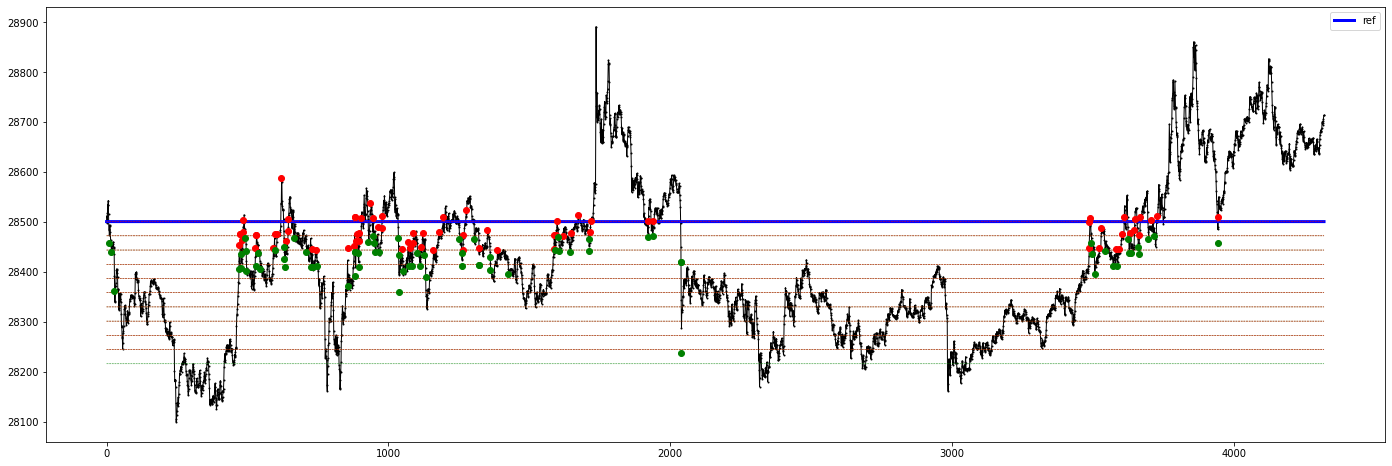

In [296]:
plt.figure(figsize=(24,8))
plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
     linewidth=1, markersize=1)

plt.plot(df.index, [grid_bot.ref_price for i in df.index ], color='blue', linewidth=3, label='ref')
plt.plot(df.index, [grid_bot.buy_orders for i in df.index ], color ='green', linewidth =0.5, linestyle='--' )
plt.plot(df.index, [grid_bot.sell_orders for i in df.index ] , color ='red', linewidth =0.5, linestyle='--')

plt.plot([i[0] for i in grid_bot.sell_points], [i[1] for i in grid_bot.sell_points] , 'ro', linewidth =2)
plt.plot([i[0] for i in grid_bot.buy_points], [i[1] for i in grid_bot.buy_points] , 'go', linewidth =2)

plt.legend()
plt.show()